In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path = 'ontario_data/'
#current day
df3 = pd.read_csv(path + 'conposcovidloc(4-13).csv')
df3.columns = [x.lower() for x in df3.columns]
tor_df = df3.loc[df3['reporting_phu_city']=='Toronto']
tor_df = tor_df.groupby('accurate_episode_date')
df3 = df3.groupby('accurate_episode_date')



X3 = df3.count().iloc[:,1]    # for ontario
region = 'Ontario'


# X3 = tor_df.count().iloc[:,1]   # for toronto
# region = 'Toronto'

# X3.drop(X3.tail(2).index,inplace=True)

In [3]:
from math import exp, sqrt
from scipy import optimize


#guassian function
def fx(x, a,b,c):
    return a*np.exp(-(x-b)**2/(2*(c**2)))


rsquare: 0.8744432360434845


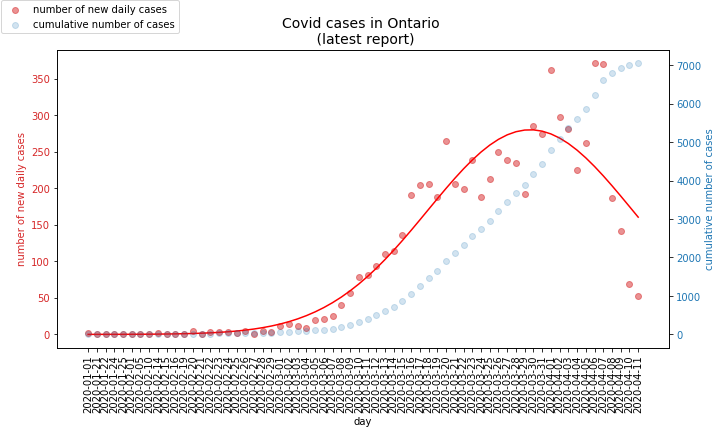

In [4]:
# Figure 2
Xc = pd.DataFrame(X3)


Xc['total'] = Xc.cumsum()
Xc = Xc.reset_index(drop=False)

Xc = Xc.rename(columns={'accurate_episode_date':'date', 'age_group': 'daily'})



data1 = [Xc['date'], Xc['daily']]
data2 = [Xc['date'], Xc['total']]

fig, ax1 = plt.subplots(facecolor='w', figsize=(10,6))

color = 'tab:red'
ax1.set_xlabel('day')
ax1.set_ylabel('number of new daily cases', color=color)
ax1.scatter(*data1, color=color, alpha = 0.5, label='number of new daily cases')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=90)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('cumulative number of cases', color=color)  # we already handled the x-label with ax1
ax2.scatter(*data2, color=color, alpha=0.2, label = 'cumulative number of cases')
ax2.tick_params(axis='y', labelcolor=color)

Xx = np.array(Xc.index)
yy = np.array(Xc['daily'])

# regression
bounds = ([50,15,0],[20000,90,20])
params, params_cov = optimize.curve_fit(fx,Xx,yy, bounds=bounds)
# print(params)

# residuals
residuals = yy - fx(Xx,*params)
ssres = np.sum(residuals**2)
sstot = np.sum((yy-np.mean(yy))**2)
rsquared = 1-(ssres/sstot)
print('rsquare: {}'.format(rsquared))

ax1.plot(fx(Xx,*params), c='r')
ax1.set_title('Covid cases in {} \n (latest report)'.format(region), fontsize=14)

fig.legend(borderaxespad=0.1, loc='upper left')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.tight_layout()
# plt.savefig('./o_figures/figure2.png', dpi=300)


plt.show()


C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


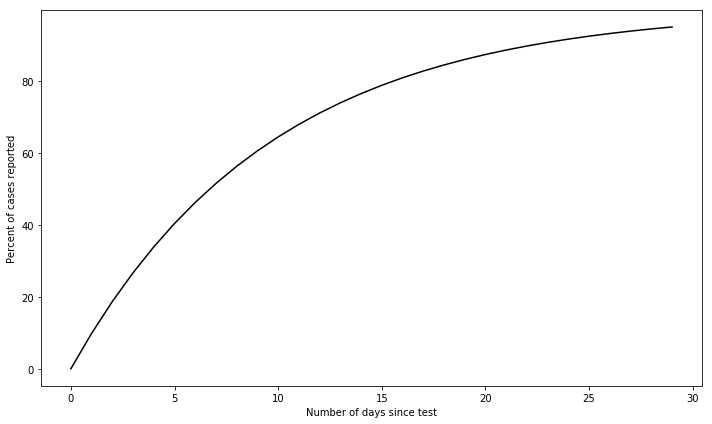

In [5]:
# figure 3
# modeling exponential hazard

x = np.linspace(0,30,30) # days

def complete(r,t): #exponential hazard
    return 1 - np.exp(-r*t)

r = 1/10  # 1/average time of onset to reportin

y = complete(r,x)

def lag_cases(y):
    return 1/y

yy = lag_cases(y)


plt.figure(figsize=(10,6))
plt.plot(y*100, c='k')
# plt.plot(yy)
plt.yticks()

plt.xlabel('Number of days since test')
plt.ylabel('Percent of cases reported')
plt.tight_layout()
plt.savefig('./o_figures/figure3.png', dpi=300)

plt.show()



In [6]:
yy

array([        inf, 10.17528582,  5.35056242,  3.74804287,  2.95105142,
        2.4762458 ,  2.16250615,  1.94077632,  1.77652423,  1.65056203,
        1.55137414,  1.47163007,  1.40644077,  1.35241982,  1.30714694,
        1.26884608,  1.23618427,  1.20814142,  1.18392357,  1.16290349,
        1.1445791 ,  1.12854379,  1.11446482,  1.10206734,  1.09112239,
        1.08143783,  1.07285127,  1.06522466,  1.05843994,  1.0523957 ])

In [7]:
from datetime import datetime, date
now = datetime.now()
d0 = datetime(2020, 1, 21)

# timespan = now - d0


latest_date = datetime.strptime(Xc['date'].iloc[-1],'%Y-%m-%d')


delta = now-latest_date


In [8]:
Xc = pd.DataFrame(X3)
Xc['total'] = Xc.cumsum()
Xc = Xc.reset_index(drop=False)

Xc = Xc.rename(columns={'accurate_episode_date':'date', 'age_group': 'daily'})

corrected = Xc
days_to_add = len(corrected) - len(yy[:-delta.days])
for ones in range(days_to_add):
    yy = np.append(yy,1)
    
corrected['lag_factor'] = yy[::-1][:-delta.days].tolist() #reverses array

corrected['corrected_daily'] = corrected['daily'] * corrected['lag_factor']
corrected['corrected_total'] = Xc['corrected_daily'].cumsum()

rsquare: 0.8598093738241135


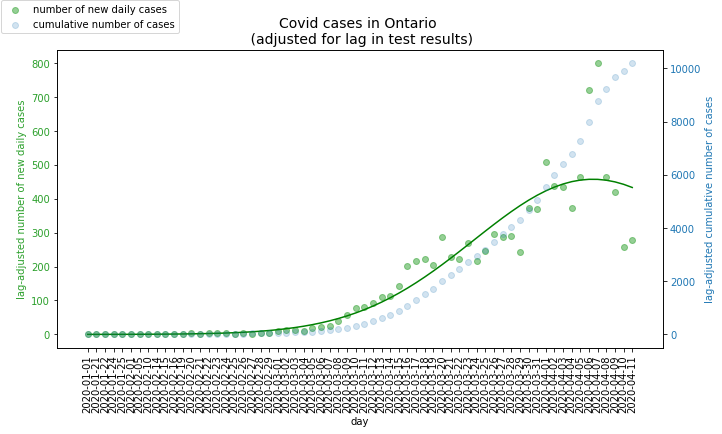

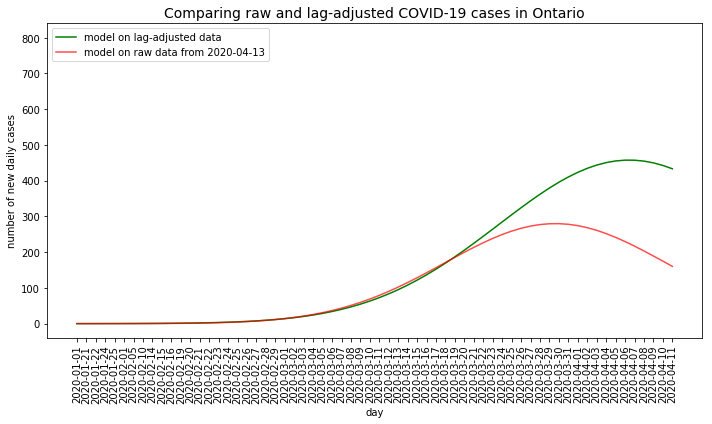

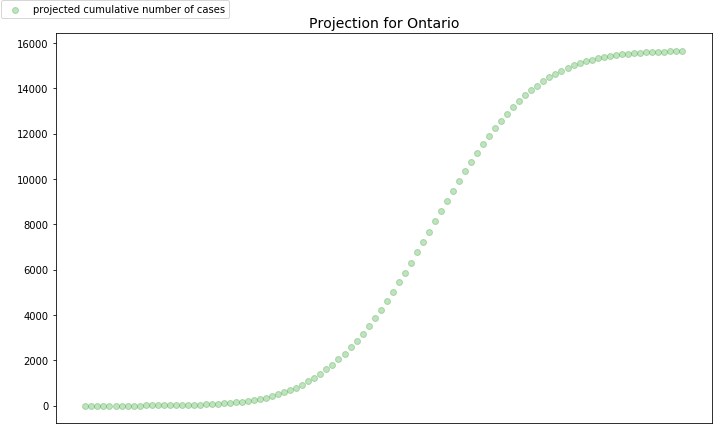

estimated total after 100 days: 15,642


In [9]:
# Figure 5
data1 = [corrected['date'], corrected['corrected_daily']]
data2 = [corrected['date'], corrected['corrected_total']]

fig, ax1 = plt.subplots(facecolor='w', figsize=(10,6))

color = 'tab:green'
ax1.set_xlabel('day')
ax1.set_ylabel('lag-adjusted number of new daily cases', color=color)
ax1.scatter(*data1, color=color, alpha = 0.5, label='number of new daily cases')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=90)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('lag-adjusted cumulative number of cases', color=color)  # we already handled the x-label with ax1
ax2.scatter(*data2, color=color, alpha=0.2, label = 'cumulative number of cases')
ax2.tick_params(axis='y', labelcolor=color)

Xx = np.array(corrected.index)
yy = np.array(corrected['corrected_daily'])

# regression
bounds = ([50,15,0],[20000,90,20])
c_params, params_cov = optimize.curve_fit(fx,Xx,yy, bounds=bounds)
# print(params)

# residuals
residuals = yy - fx(Xx,*c_params)
ssres = np.sum(residuals**2)
sstot = np.sum((yy-np.mean(yy))**2)
rsquared = 1-(ssres/sstot)
print('rsquare: {}'.format(rsquared))

ax1.plot(fx(Xx,*c_params), c='g')
ax1.set_title('Covid cases in {} \n (adjusted for lag in test results)'.format(region), fontsize=14)

fig.legend(borderaxespad=0.1, loc='upper left')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

# plt.tight_layout()

# plt.savefig('./o_figures/figure5.png', dpi=300)

plt.show()


# Figure 6

color = 'k'
fig, ax1 = plt.subplots(facecolor='w', figsize=(10,6))
ax1.set_title('Comparing raw and lag-adjusted COVID-19 cases in {}'.format(region),fontsize=14)

ax1.set_xlabel('day')
ax1.set_ylabel('number of new daily cases', color=color)
ax1.scatter(*data1, color=color, alpha = 0, label='')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=90)


ax1.plot(fx(Xx,*c_params), c='g', label = 'model on lag-adjusted data')

ax1.plot(fx(Xx,*params), c='r',alpha=0.7, label = 'model on raw data from {}'.format(now.strftime('%Y-%m-%d')))
# ax1.plot(fx(Xx,*params0), c='r',alpha=0.3, label = 'model on raw data from April 2nd')
fig.tight_layout()
plt.legend()
# plt.savefig('./o_figures/figure6.png', dpi=300)

plt.show()


days = 100
t = np.linspace(0,days,days)

y1 = fx(t,*c_params)
red = [Xx, yy]
blue = [t, np.cumsum(y1)]



fig, ax1 = plt.subplots(facecolor='w', figsize=(10,6))
ax1.set_title('Projection for {}'.format(region), fontsize=14)


color = 'tab:green'
ax1.scatter(*blue, color=color, alpha=0.3, label = 'projected cumulative number of cases')


fig.legend(borderaxespad=0.1, loc='upper left')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tight_layout()


plt.show()

print('estimated total after {0} days: {1:,}'.format(days,int(np.cumsum(y1)[-1])))

In [10]:
# corrected

In [11]:
dsdt_from_data = corrected.iloc[61]['corrected_total'] - corrected.iloc[60]['corrected_total']
dsdt_from_data

419.04930160227923

In [12]:
# get beta
# dsdt = dsdt_from_data   #change from precious day
dsdt = 401   #change from precious day
n = 14570000    #total pop
it = 3654       # currently infectious
rt = 3395       # currently recovered
st = n - rt     # currently suscptible
beta_from_data = (dsdt * n)/(st * it)
beta_from_data

0.10976832512496948

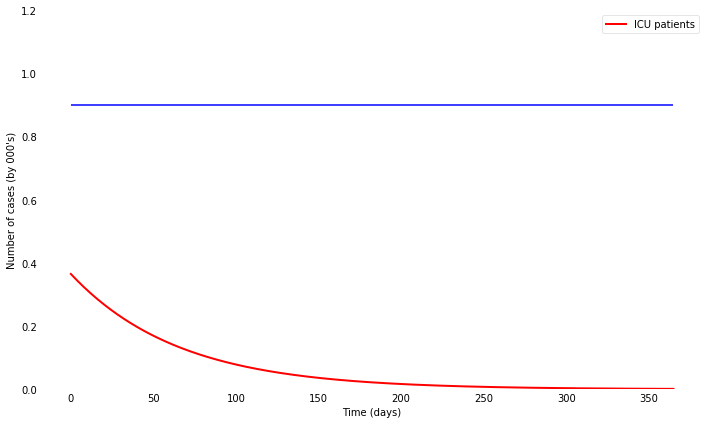

In [15]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline

# total population
N = 14570000

# initial number of infected and recovered
I0 = 3654
R0 = 3395

# everyone else
S0 = N- I0 - R0


#rates (in 1/days)
rnot = 1.5      # estimated to be between 1.4 - 3.8
gamma = 1/8      # time to recovery or death (average of 14 days)
# beta = rnot*gamma     # infection rate
beta = beta_from_data

# create grid of time points 
days = 365
t = np.linspace(0,days,days)

# differential equations with SIR model
def deriv(y, t, N, beta, gamma):
    S, I, R, = y
    dSdt = -beta*S*I / N
    dIdt = (beta*S*I/N) - gamma*I
    dRdt = gamma*I
    return dSdt, dIdt, dRdt

# create initial conditions vector
y0 = S0, I0, R0

# integration SIR equation over time space
ret = odeint(deriv, y0, t, args=(N,beta,gamma))
S, I, R = ret.T

# hospitalization rate
h_rate = 0.10

# Plot the data on three separate curves for S(t), I(t) and R(t)

fig = plt.figure(facecolor='w',figsize=(10, 6))
ax = fig.add_subplot(111, axisbelow=True)
# ax.plot(t, S/1000, 'k', alpha=0.5, lw=2, label='S(t)')
# ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='I(t)')
ax.plot(t, (I/1000)*h_rate, 'r', alpha=1, lw=2, label='ICU patients')
# ax.plot(t, R/1000, 'green', alpha=1, lw=2, label='R(t)')
ax.set_xlabel('Time (days)')
ax.set_ylabel("Number of cases (by 000's)")
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

# health system capacity
cap = 900
ax.hlines(y=cap/1000,xmin=0, xmax=t[-1], color='b')
    
plt.tight_layout()

# plt.savefig('./figures/figure1.png', dpi=300)
# plt.show()

In [16]:
(I)*h_rate

array([365.4       , 359.84175285, 354.36699521, 348.97450465,
       343.66307625, 338.43152179, 333.2786695 , 328.20336393,
       323.20446573, 318.28085143, 313.43141326, 308.65505897,
       303.95071159, 299.31730932, 294.75380528, 290.25916734,
       285.83237791, 281.47243375, 277.17834582, 272.94913905,
       268.78385227, 264.68153802, 260.64126224, 256.6621042 ,
       252.74315629, 248.88352388, 245.08232513, 241.33869075,
       237.651764  , 234.02070038, 230.44466756, 226.9228452 ,
       223.45442477, 220.03860933, 216.67461346, 213.36166309,
       210.09899537, 206.88585848, 203.72151147, 200.60522418,
       197.53627702, 194.51396087, 191.53757693, 188.60643657,
       185.71986119, 182.87718211, 180.07774039, 177.32088671,
       174.60598128, 171.93239365, 169.29950261, 166.70669607,
       164.1533709 , 161.63893284, 159.16279635, 156.72438452,
       154.32312892, 151.9584695 , 149.62985446, 147.33674011,
       145.07859082, 142.85487885, 140.66508427, 138.50